Let's talk a little bit about nn.Embedding layers.

The weights are initialized randomly, so you can train them like any other model. The point is to get each word in the vocabulary as a continuous vector in the embedding space. So in the beginning, cat and dog might not be near each other (because it's random). But after training they should be nearby each other.

We train it with a sequence of integers 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [2]:
from datasets import load_dataset

# Load the IMDB dataset
dataset = load_dataset("imdb")

# Split the dataset into training and testing subsets
train_data = dataset["train"]
test_data = dataset["test"]

# Take a subset of the data for faster training
train_data = train_data.select(range(int(0.05 * len(train_data))))


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /Users/jsimonelli/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 1250
})

Now we have to tokenize this

In [16]:
type(train_data)

datasets.arrow_dataset.Dataset

Let's look at an example.

In [22]:
train_iter = iter(train_data)
for _ in range(10):
    sample = next(train_iter)
    print(f"{sample['label'], sample['text'][:200]}")

(0, 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev')
(0, '"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn\'t matter what one\'s political views are because this film can hardly be taken seriously on any level. As for the claim that ')
(0, 'If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches ')
(0, "This film was probably inspired by Godard's Masculin, féminin and I urge you to see that film instead.<br /><br />The film has two strong elements and those are, (1) the realistic acting (2) the impre")
(0, 'Oh, brother...after hearing about this ridiculous film for umpteen years all I can think of is that old Peggy Lee song..<br /><br />"Is that all there is??" ...I

In [3]:
corpus = [
    "the quick brown fox jumps over the lazy dog",
    "the quick brown dog jumps over the lazy fox",
    "the lazy brown fox jumps over the quick dog",
]

def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

tokenized_corpus = tokenize_corpus(corpus)


In [4]:
def create_vocabulary(tokenized_corpus):
    vocabulary = {}
    for sentence in tokenized_corpus:
        for token in sentence:
            if token not in vocabulary:
                vocabulary[token] = len(vocabulary)
    return vocabulary

vocabulary = create_vocabulary(tokenized_corpus)


In [5]:
vocabulary

{'the': 0,
 'quick': 1,
 'brown': 2,
 'fox': 3,
 'jumps': 4,
 'over': 5,
 'lazy': 6,
 'dog': 7}

In [6]:
embedding_dim = 50

class EmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(EmbeddingModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, input):
        return self.embeddings(input)

model = EmbeddingModel(len(vocabulary), embedding_dim)


In [7]:
model

EmbeddingModel(
  (embeddings): Embedding(8, 50)
)

We'll train it with the Skip-Gram approach

In [8]:
window_size = 2

def generate_training_data(tokenized_corpus, vocabulary, window_size):
    training_data = []
    for sentence in tokenized_corpus:
        indices = [vocabulary[word] for word in sentence]
        for center_word_pos in range(len(indices)):
            for w in range(-window_size, window_size + 1):
                context_word_pos = center_word_pos + w
                if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                    continue
                training_data.append((indices[center_word_pos], indices[context_word_pos]))
    return training_data

training_data = generate_training_data(tokenized_corpus, vocabulary, window_size)


In [9]:
training_data

[(0, 1),
 (0, 2),
 (1, 0),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 4),
 (3, 1),
 (3, 2),
 (3, 4),
 (3, 5),
 (4, 2),
 (4, 3),
 (4, 5),
 (4, 0),
 (5, 3),
 (5, 4),
 (5, 0),
 (5, 6),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (6, 5),
 (6, 0),
 (6, 7),
 (7, 0),
 (7, 6),
 (0, 1),
 (0, 2),
 (1, 0),
 (1, 2),
 (1, 7),
 (2, 0),
 (2, 1),
 (2, 7),
 (2, 4),
 (7, 1),
 (7, 2),
 (7, 4),
 (7, 5),
 (4, 2),
 (4, 7),
 (4, 5),
 (4, 0),
 (5, 7),
 (5, 4),
 (5, 0),
 (5, 6),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 3),
 (6, 5),
 (6, 0),
 (6, 3),
 (3, 0),
 (3, 6),
 (0, 6),
 (0, 2),
 (6, 0),
 (6, 2),
 (6, 3),
 (2, 0),
 (2, 6),
 (2, 3),
 (2, 4),
 (3, 6),
 (3, 2),
 (3, 4),
 (3, 5),
 (4, 2),
 (4, 3),
 (4, 5),
 (4, 0),
 (5, 3),
 (5, 4),
 (5, 0),
 (5, 1),
 (0, 4),
 (0, 5),
 (0, 1),
 (0, 7),
 (1, 5),
 (1, 0),
 (1, 7),
 (7, 0),
 (7, 1)]

Now create the training loop.

In [10]:
epochs = 100
learning_rate = 0.001
batch_size = 64

# Defining the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    epoch_loss = 0
    np.random.shuffle(training_data)

    for batch_start in range(0, len(training_data), batch_size):
        optimizer.zero_grad()

        batch = training_data[batch_start:batch_start + batch_size]

        input_batch = torch.tensor([x[0] for x in batch], dtype=torch.long)
        target_batch = torch.tensor([x[1] for x in batch], dtype=torch.long)

        # Forward pass
        embeddings = model(input_batch)
        scores = torch.matmul(embeddings, model.embeddings.weight.T)
        loss = loss_function(scores, target_batch)

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(training_data)}")


Epoch 1/100, Loss: 1.1645975748697917
Epoch 2/100, Loss: 1.1576998392740885
Epoch 3/100, Loss: 1.160050286187066
Epoch 4/100, Loss: 1.1583006117078993
Epoch 5/100, Loss: 1.1617673238118489
Epoch 6/100, Loss: 1.158350372314453
Epoch 7/100, Loss: 1.141011004977756
Epoch 8/100, Loss: 1.143779076470269
Epoch 9/100, Loss: 1.143271509806315
Epoch 10/100, Loss: 1.1319017198350694
Epoch 11/100, Loss: 1.1276723225911458
Epoch 12/100, Loss: 1.1473401387532551
Epoch 13/100, Loss: 1.114923816257053
Epoch 14/100, Loss: 1.1149561140272353
Epoch 15/100, Loss: 1.124348873562283
Epoch 16/100, Loss: 1.1025133768717448
Epoch 17/100, Loss: 1.1124415927463107
Epoch 18/100, Loss: 1.1212657080756294
Epoch 19/100, Loss: 1.0924373626708985
Epoch 20/100, Loss: 1.102300516764323
Epoch 21/100, Loss: 1.0866872999403212
Epoch 22/100, Loss: 1.097404056125217
Epoch 23/100, Loss: 1.086764187282986
Epoch 24/100, Loss: 1.0778660668267144
Epoch 25/100, Loss: 1.0741862403021918
Epoch 26/100, Loss: 1.0739973704020183
Epoch

In [11]:
embeddings = model.embeddings.weight.detach().numpy()


In [12]:
from sklearn.decomposition import PCA

# First, install the required library if you haven't already:
# pip install scikit-learn

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)


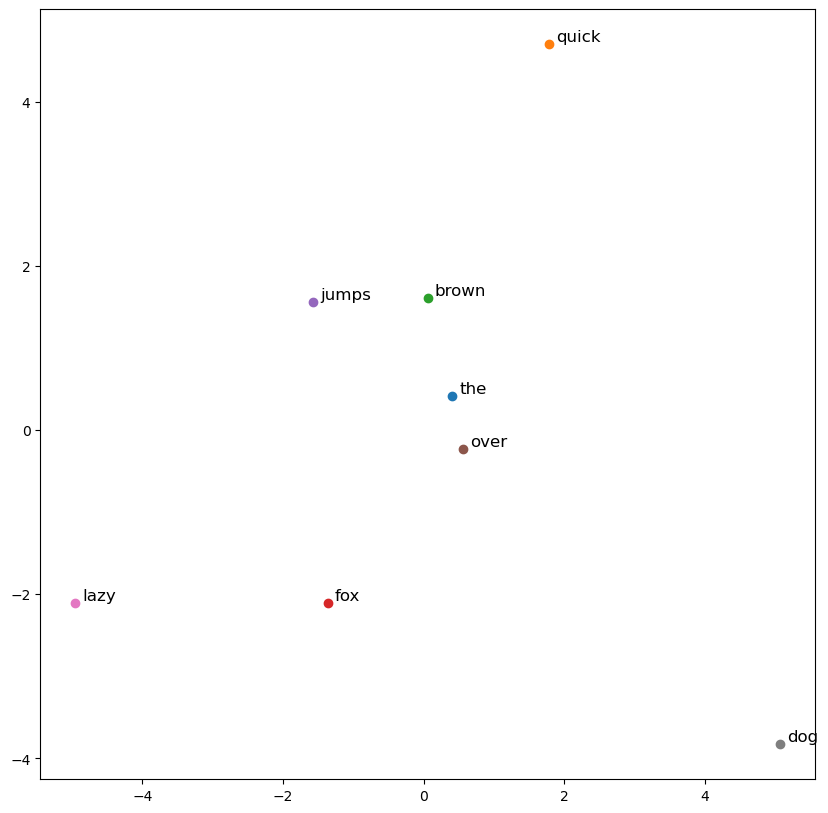

In [13]:
plt.figure(figsize=(10, 10))

for i, word in enumerate(vocabulary):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords="offset points", fontsize=12)

plt.show()